# Mastodon analysis
Expected to be run in a notebook

[DuckDB in Jupyter Notebooks](https://duckdb.org/docs/guides/python/jupyter)

In [7]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [8]:
import duckdb
import pandas as pd
import seaborn as sns

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql
%sql duckdb:///:memory:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [9]:
%%sql
INSTALL httpfs;
LOAD httpfs;

""


In [10]:
%%sql
drop table if exists mastodon_toot_raw;
drop table if exists mastodon_toot;
drop table if exists language;

CREATE TABLE language(lang_iso VARCHAR PRIMARY KEY, language_name VARCHAR);

insert into language
select *
from read_csv('../duckdb/language.csv', AUTO_DETECT=TRUE, header=True);

create table mastodon_toot_raw as
select m_id
, created_at, ('EPOCH'::TIMESTAMP + INTERVAL (created_at::INT) seconds)::TIMESTAMPTZ  as created_tz
, app
, url
, regexp_replace(regexp_replace(url, '^http[s]://', ''), '/.*$', '') as from_instance
, base_url
, language
, favourites
, username
, bot
, tags
, characters
, mastodon_text
FROM read_parquet('../data_tmp/all_toots.parquet');

create table mastodon_toot as
select mr.*, ln.language_name
from mastodon_toot_raw mr left outer join language ln on (mr.language = ln.lang_iso);

,Count
0,1622149


# The Mastodon app landscape
What clients are used to access mastodon instances

In [70]:
%%sql
mastodon_app_df << 
select *
from mastodon_toot
where app is not null 
and app <> ''
and bot='False'
;

Returning data to local variable mastodon_app_df


<AxesSubplot: xlabel='count', ylabel='app'>

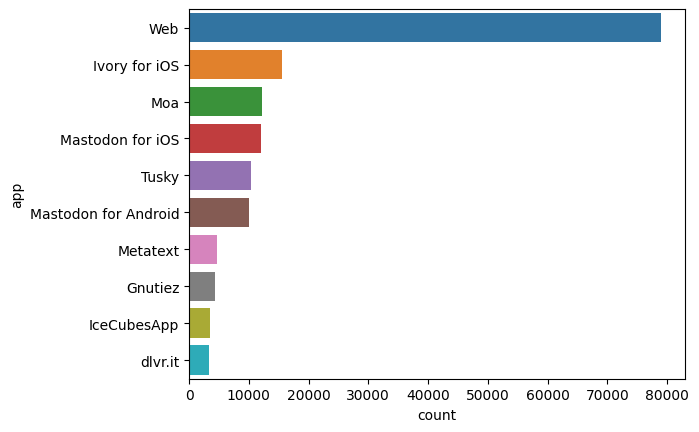

In [71]:
sns.countplot(data=mastodon_app_df, y="app", order=mastodon_app_df.app.value_counts().iloc[:10].index)

In [102]:
%%sql
select strftime(created_tz, '%Y/%m/%d %a') as "Created day"
, count(*) as "Num toots"
, count(distinct(username)) as "Num users"
, count(distinct(from_instance)) as "Num urls"
, mode(case when bot='False' then username end) as "Most freq non-bot"
, mode(case when bot='True' then username end) as "Most freq bot"
, mode(base_url) as "Most freq host"
from mastodon_toot
where created_tz between TIMESTAMP '2023-02-07 13:00:00' and TIMESTAMP '2023-02-12 12:59:59' 
group by 1
order by 1
;

,Created day,Num toots,Num users,Num urls,Most freq non-bot,Most freq bot,Most freq host
0,2023/02/08 Wed,188503,49649,4372,gnutiez,cnexnews,https://mastodon.social
1,2023/02/09 Thu,166096,48532,4227,worldeconomicfella,cnexnews,https://mastodon.social
2,2023/02/10 Fri,207877,54230,4608,gnutiez,cnexnews,https://mastodon.social
3,2023/02/11 Sat,213085,54624,4649,EwonRael,cnexnews,https://mastodon.social
4,2023/02/12 Sun,201201,49977,4507,EwonRael,J1gold,https://mastodon.social


In [106]:
%%sql
select username
, count(*) as num_toots
from mastodon_toot
where language = 'en'
and bot = 'False'
group by 1 
having count(*) between 20 and 50
order by 2 desc
;

,username,num_toots
0,mfioretti_en,50
1,ToddPM,50
2,DevinPike,50
3,footiebuzz,50
4,jonn,50
...,...,...
5392,KydiaMusic,20
5393,alexthecamel,20
5394,shayneoneill,20
5395,nengeg,20


In [107]:
%%sql
select *
from mastodon_toot
where username = 'DevinPike'
;

,m_id,created_at,created_tz,app,url,from_instance,base_url,language,favourites,username,bot,tags,characters,mastodon_text,language_name
0,109843918895278067,1676085188,2023-02-11 03:13:08,,https://mastodon.world/@DevinPike/109843918806...,mastodon.world,https://mastodon.social,en,0,DevinPike,False,3,220,I repeat: Felissa Rose is a goddamned national...,English
1,109843857334524114,1676084249,2023-02-11 02:57:29,,https://mastodon.world/@DevinPike/109843857203...,mastodon.world,https://mastodon.social,en,0,DevinPike,False,3,136,This mall manager is an absolute spokesperson ...,English
2,109837981162695222,1675994589,2023-02-10 02:03:09,,https://mastodon.world/@DevinPike/109837980957...,mastodon.world,https://mastodon.social,en,0,DevinPike,False,1,234,"Had a hunch, so I threw in SLAP SHOT (1977). A...",English
3,109843822952323390,1676083724,2023-02-11 02:48:44,,https://mastodon.world/@DevinPike/109843822847...,mastodon.world,https://mastodon.social,en,0,DevinPike,False,3,134,"The more bourbon I drink, the more “natural” t...",English
4,109843939306558669,1676085499,2023-02-11 03:18:19,,https://mastodon.world/@DevinPike/109843939278...,mastodon.world,https://mastodon.social,en,0,DevinPike,False,3,89,“Why do you do this?” #TheLastDriveIn #MutantF...,English
5,109843924911540418,1676085280,2023-02-11 03:14:40,,https://mastodon.world/@DevinPike/109843924885...,mastodon.world,https://mastodon.social,en,0,DevinPike,False,3,132,HOLY GOD MILLER’S OUTPOST AND CASUAL CORNER I ...,English
6,109843882627528212,1676084635,2023-02-11 03:03:55,,https://mastodon.world/@DevinPike/109843882545...,mastodon.world,https://mastodon.social,en,0,DevinPike,False,3,133,HOLY GOD MILLER’S CROSSONG AND CASUAL CORNER I...,English
7,109852668169351867,1676218692,2023-02-12 16:18:12,,https://mastodon.world/@DevinPike/109852668105...,mastodon.world,https://mastodon.social,en,0,DevinPike,False,0,239,"It’s 2023, and “trunk rattle” is still a thing...",English
8,109849180746062567,1676165478,2023-02-12 01:31:18,,https://mastodon.world/@DevinPike/109849180717...,mastodon.world,https://mastodon.social,en,0,DevinPike,False,4,149,Question for the peanut gallery:Do any of you ...,English
9,109843780616124776,1676083078,2023-02-11 02:37:58,,https://mastodon.world/@DevinPike/109843780587...,mastodon.world,https://mastodon.social,en,0,DevinPike,False,3,95,BRENNAN LAYING DOWN THE LAW #TheLastDriveIn @D...,English


In [28]:
%%sql
mastodon_usage_df << 
select strftime(created_tz, '%Y/%m/%d %a') as created_day
, date_part('hour', created_tz) as created_hour
, count(*) as num
from mastodon_toot
group by 1,2 
order by 1,2
;

Returning data to local variable mastodon_usage_df


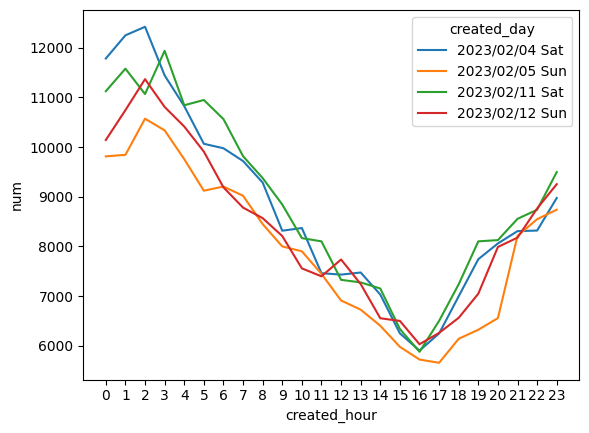

In [68]:
# sns.lineplot(data=mastodon_usage_df, x="created_hour", y="num")
df = mastodon_usage_df[mastodon_usage_df['created_day'].isin(['2023/02/04 Sat', '2023/02/05 Sun', '2023/02/11 Sat', '2023/02/12 Sun'] ) ]
sns.lineplot(data=df  , x="created_hour", y="num", hue="created_day").set_xticks(range(24))

# Language usage
A wildly inaccurate investigation of language tags

In [22]:
%%sql
mastodon_usage_df << 
select *
from mastodon_toot;

Returning data to local variable mastodon_usage_df


<AxesSubplot: xlabel='count', ylabel='language_name'>

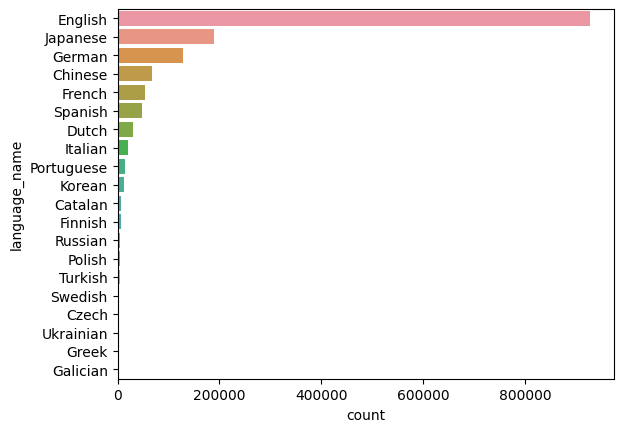

In [24]:
sns.countplot(data=mastodon_usage_df, y="language_name", order=mastodon_usage_df.language_name.value_counts().iloc[:20].index)

In [25]:
%%sql
mastodon_lang_df << 
select *
from mastodon_toot
where characters < 200
and language not in ('unknown');

Returning data to local variable mastodon_lang_df


<AxesSubplot: xlabel='characters', ylabel='language_name'>

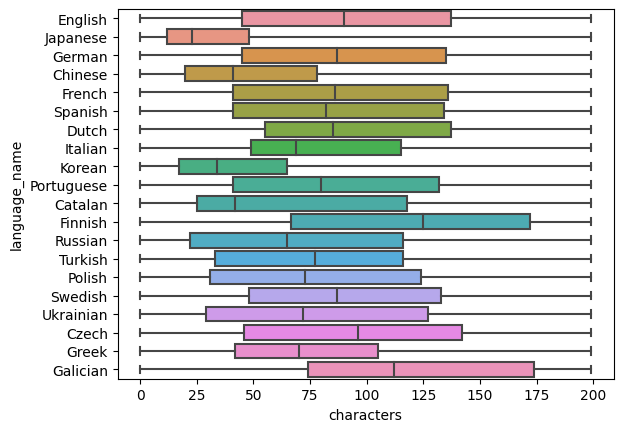

In [26]:
sns.boxplot(data=mastodon_lang_df, x="characters", y="language_name", whis=100, orient="h", order=mastodon_lang_df.language_name.value_counts().iloc[:20].index)
